Multimodality deals with how to model both preference data and some content data either on user or item side(other modalities).

In [ ]:
!pip install --quiet cornac==1.15.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 45.8 MB/s eta 0:00:00


In [ ]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd; pd.set_option("max_colwidth", 0)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cornac
from cornac.utils import cache
from cornac.datasets import filmtrust, amazon_clothing
from cornac.eval_methods import RatioSplit
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer
import tensorflow as tf

SEED = 42
VERBOSE = False

##Graph Modality

###Social Recommendation (SoRec)

The idea is fusing user-item rating matrix with user's social network.  
R: user-item rating matrix  
G: user-user grapj adjacency matrix  
U: user latent vectors  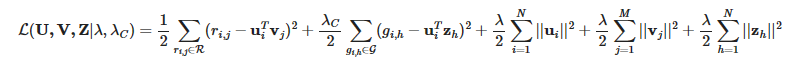  
Screenshot 2023-05-24 001955.png : relative importance of the soical network factorization  
Screenshot 2023-05-24 002201.png: regularization weight

Comparision between SoRec and its base model PMF on FilmTrust dataset

In [ ]:
K = 20
sorec = SoRec(k=K, max_iter=50, learning_rate=0.001, verbose=VERBOSE, seed=SEED)
pmf = PMF(k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED)

ratings = filmtrust.load_feedback()
trust = filmtrust.load_trust()

user_graph_modality = GraphModality(data=trust)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=2.5,
    exclude_unknowns=True,
    user_graph=user_graph_modality,
    verbose=VERBOSE,
    seed=SEED,
)

mae = cornac.metrics.MAE()

cornac.Experiment(eval_method=ratio_split, models=[sorec, pmf], metrics=[mae]).run()

Data from https://static.preferred.ai/cornac/datasets/filmtrust/filmtrust.zip
will be cached into /root/.cornac/filmtrust/ratings.txt


0.00B [00:00, ?B/s]

Unzipping ...
File cached!


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:361: UserWarning: 3 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



TEST:
...
      |    MAE | Train (s) | Test (s)
----- + ------ + --------- + --------
SoRec | 0.6644 |    1.6204 |   0.4167
PMF   | 0.7018 |    0.9921 |   0.4038



SoRec achieves lower MAE score than PMF

##Interpreting Recommendation

The variance of each user latent dimension:

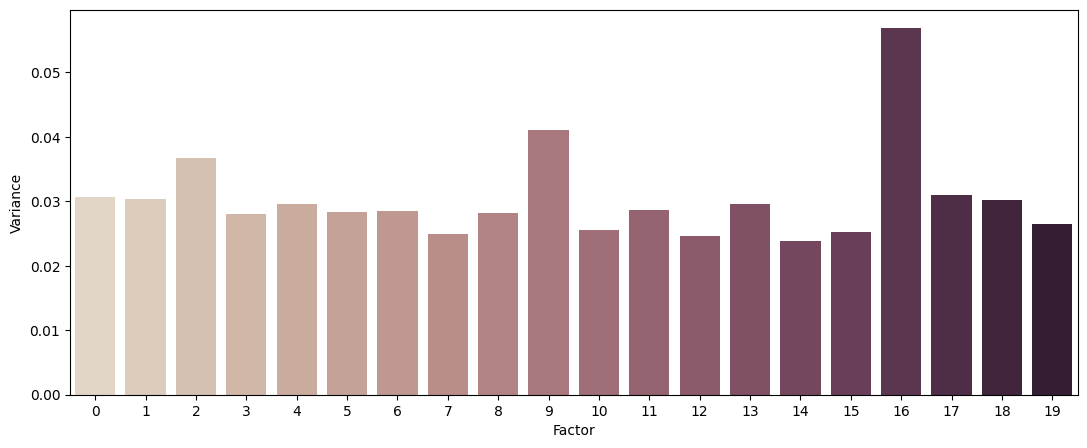

In [ ]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(sorec.U, axis=0)}) #create dataframe
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);
     

Select two dimensions and see how users are distributed in 2D space. We can visualize connections between two users if they are linked in the social network.

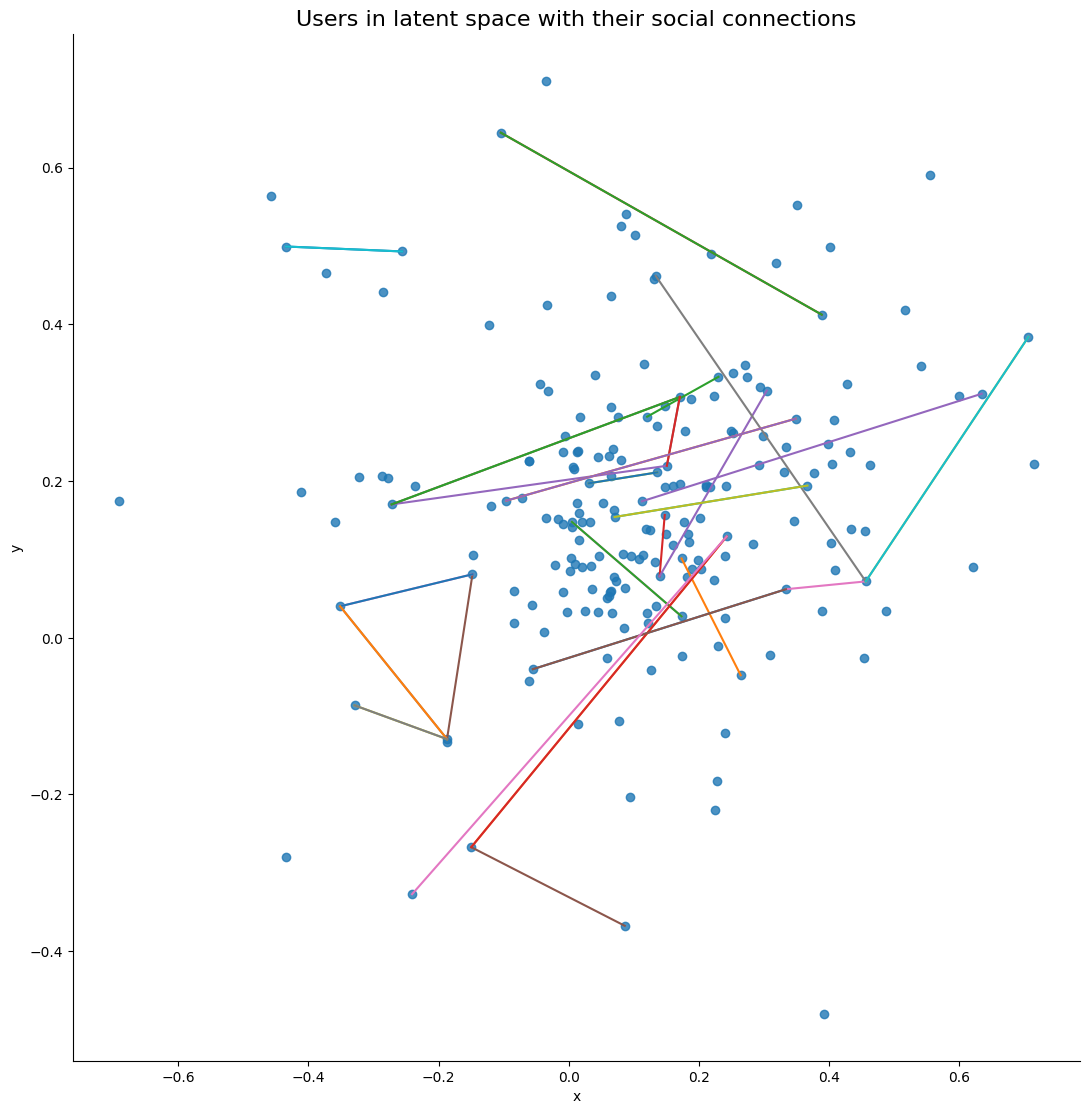

In [ ]:
TOP2F = (9, 19)
SAMPLE_SIZE = 200

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(sorec.U.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=sorec.U[sample_inds][:, TOP2F], columns=["x", "y"])
g = sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
g.ax.set_title("Users in latent space with their social connections", fontsize=16)

adj_mat = sorec.train_set.user_graph.matrix
for i in range(len(sample_inds)):
  for j in range(len(sample_inds)):
    if j != i and adj_mat[sample_inds[i], sample_inds[j]]:
      sns.lineplot(x="x", y="y", data=sample_df.loc[[i, j]])

##Text Modality

###Colaborative Topic Regression (CTR)



CTR is a recommendation model that combines matrix fectorization and probablistic topic modeling.  
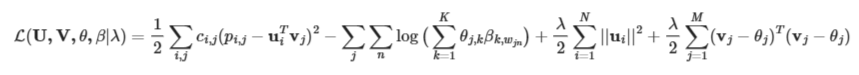  
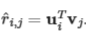  
- ui: user latent vectors  
- vj: item latent vectors  
- phi j: current topic propotions  
- beta k: topic words
- pi,j: adoption
- ci,j: confidence  
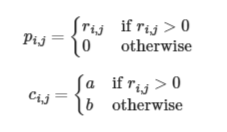  
Let's experiment with two models CTR and WMF on a dataset from Amazon Clothing category. Using this dataset, CTR will learn topics from item description.

In [ ]:
K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01, 
          verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000, #limit the maximum vocabulary size to 8000
    max_doc_freq=0.5, #filter out words occuring in more than 50% of documents
)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2, #test size 20%
    rating_threshold=4.0, #binarize ratings values into positive and negative feedback for model evaluation
    exclude_unknowns=True, #if true, unknown users and items will be ignored during model evaluation
    item_text=item_text_modality,
    verbose=VERBOSE,
    seed=SEED,
)

rec_50 = cornac.metrics.Recall(50)

cornac.Experiment(eval_method=ratio_split, models=[ctr, wmf], metrics=[rec_50]).run()

Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/rating.zip
will be cached into /root/.cornac/amazon_clothing/rating.txt


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/text.zip
will be cached into /root/.cornac/amazon_clothing/text.txt


0.00B [00:00, ?B/s]

Unzipping ...
File cached!

TEST:
...
    | Recall@50 | Train (s) | Test (s)
--- + --------- + --------- + --------
CTR |    0.2239 |  133.8494 |   1.1752
WMF |    0.1582 |   21.8807 |   1.1461



###Interpreting Recommendation
Let see what the top words of each topic are, based on learned topic-word distributions beta 

In [ ]:
vocab = ctr.train_set.item_text.vocab 
topic_word_dist = ctr.model.beta.T[:, -ctr.train_set.item_text.max_vocab:]  #select the col of most frequent words
top_word_inds = np.argsort(topic_word_dist, axis=1) + 4  # ingore 4 special tokens

topic_words = {}
topic_df = defaultdict(list)
print("WORD TOPICS:")
for t in range(len(topic_word_dist)):
  top_words = vocab.to_text(top_word_inds[t][-10:][::-1], sep=", ")
  topic_words[t+1] = top_words
  topic_df["Topic"].append(t + 1)
  topic_df["Top words"].append(top_words)
topic_df = pd.DataFrame(topic_df)
topic_df

WORD TOPICS:


,Topic,Top words
0,1,"belt, flatlock, case, size, better, choose, earrings, soft, warm, collar"
1,2,"shirt, style, breathable, princess, youre, colors, quality, come, people, socks"
2,3,"easy, collection, colors, rubber, water, quickly, stretch, lightweight, design, body"
3,4,"activities, handle, helmet, star, way, flat, makes, day, half, tee"
4,5,"fit, sweat, mesh, large, pocket, fleece, body, necklace, imported, travel"
5,6,"wicks, material, dry, fit, panels, piece, insect, construction, durability, standard"
6,7,"support, company, fabric, apparel, fun, sizes, hip, outdoor, fiber, features"
7,8,"x, merino, sleeve, fun, items, water, weather, bracelets, comfortable, display"
8,9,"great, performance, black, pockets, inches, make, away, design, jewelry, unique"
9,10,"fits, sun, store, engineered, pocket, shield, conditions, mobility, hat, maximum"


As item vectors are close to its topic proportions, user vectors can also be used to explain what topics they are interested in.

In [ ]:
UIDX = 123
TOPK = 5

item_id2idx = ctr.train_set.iid_map
item_idx2id = list(ctr.train_set.item_ids)

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 123 TOP-3 TOPICS:


,Topic,Top words
14,15,"high, storage, height, waistband, wide, way, chest, include, growth, new"
13,14,"size, comfortable, product, warm, need, ua, accessory, clean, footwear, silver"
12,13,"s, use, sure, soft, comfort, easy, products, skin, displays, moisture"


What will be recommendations to this user?

In [ ]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 123:


,URL,Description
0,https://www.amazon.com/dp/B002M62ES6,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.
1,https://www.amazon.com/dp/B002MKPKFG,"This glamorous dress is perfect for a night at the ball. The stretchy blue velvet bodice is elegantly detailed with a gathered white inlay, ruffled cap sleeves, sparkling silver trim and a white rose. The silver trimmed waist drapes outlined with ruffle capture that authentic Cinderella look.The dress is designed with an empire waist that sits 1.5 inches above the waist. They are machine washable and made for long repeated use, unlike many one-off Halloween costumes that are not made for everyday play. Our stretchy accommodating fabrics will allow for a comfortable fit for each child within the respective age ranges and there are no itchy fabrics or trims.Each dress comes with an exclusive Princess Hairbow as part of the bundle set."
2,https://www.amazon.com/dp/B001NAHW2U,LACY 14K GOLD on 925 Silver Charm BEAD compatible with European Bracelet
3,https://www.amazon.com/dp/B000HS6NEC,"Includes jacket, elastic pants, hat, belt, whistle, and gun holster. Child Size Small (4-6)."
4,https://www.amazon.com/dp/B001EDF3OU,The Child Indiana Jones Hat and Whip are two must have accessories for your child's Officially Licensed Indiana Jones costume. This Indiana Jones costume accessory contains the two hallmarks of Indy's style: his awesome whip and his trademark hat.


Let's check out another user with index = 321. Similarly, we see the top-3 topics this user cares most about:

In [ ]:
UIDX = 321

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 321 TOP-3 TOPICS:


,Topic,Top words
19,20,"complete, wear, fabric, features, display, measures, merino, technology, gift, want"
2,3,"easy, collection, colors, rubber, water, quickly, stretch, lightweight, design, body"
10,11,"costume, products, small, inside, classic, lightweight, comfort, white, ideal, designed"


##Image Modality

###Visual Bayesian Personalized Ranking (VBPR)
The novelty of VBPR is on how item visual features incorporated into the matrix factorization framework.  
The predicted rating user i give to item j is:  
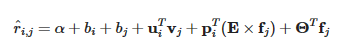  
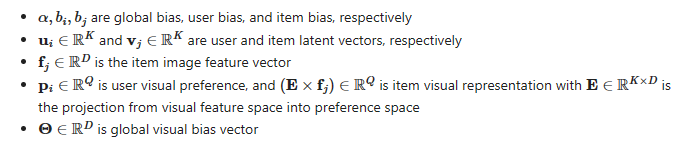  
Let's compare VBPR and BPR models with an experiment on Amazon Clothing dataset.

In [ ]:
K = 10
vbpr = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)
bpr = BPR(k=(K * 2), max_iter=50, learning_rate=0.001, lambda_reg=0.001, verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
img_features, item_ids = amazon_clothing.load_visual_feature()

item_image_modality = ImageModality(features=img_features, ids=item_ids, normalized=True)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_image=item_image_modality,
    verbose=VERBOSE,
    seed=SEED,
)

auc = cornac.metrics.AUC() # Area Under the Curve, higher value of the AUC indicatea a better quality

cornac.Experiment(eval_method=ratio_split, models=[vbpr, bpr], metrics=[auc]).run()

Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/image.zip
will be cached into /root/.cornac/amazon_clothing/image_features.npy


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/item_ids.zip
will be cached into /root/.cornac/amazon_clothing/item_ids.txt


0.00B [00:00, ?B/s]

Unzipping ...
File cached!
Optimization finished!

TEST:
...
     |    AUC | Train (s) | Test (s)
---- + ------ + --------- + --------
VBPR | 0.7053 |   56.9559 |   4.9607
BPR  | 0.5992 |    0.1129 |   2.5133



###Interpreting Recommendation
 Let's take a look at items rated by a particular user.

In [ ]:
UIDX = 111

item_id2idx = vbpr.train_set.iid_map
item_idx2id = list(vbpr.train_set.item_ids)
img_features = vbpr.train_set.item_image.features
item_desc = {iid: desc for desc, iid in zip(*amazon_clothing.load_text())}
#zip() used to map the similar index of multiple containers, using a single entity
print(f"RATED ITEMS BY USER {UIDX}:")
rated_items = np.nonzero(vbpr.train_set.matrix[UIDX].A)[1]
rated_df = defaultdict(list)
for i in rated_items:
  rated_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rated_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rated_df)

RATED ITEMS BY USER 111:


,URL,Description
0,https://www.amazon.com/dp/B00BXQF1XG,"Disguise Boy's Marvel Ultimate Spider-Man Classic Costume, 3T-4T Jumpsuit."
1,https://www.amazon.com/dp/B002M62ES6,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.


Let's see how VBPR model recommends to the user.

In [ ]:
TOPK = 5

recommendations, scores = vbpr.rank(UIDX)

print(f"\nTOP {TOPK} RECOMMENDATIONS:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  cf_contrib = vbpr.beta_item[i] + np.dot(vbpr.gamma_item[i], vbpr.gamma_user[UIDX])
  vis_contrib = vbpr.visual_bias[i] + np.dot(vbpr.theta_item[i], vbpr.theta_user[UIDX])
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Score"].append(scores[i])
  rec_df["CF Contribution"].append(cf_contrib)
  rec_df["Visual Contribution"].append(vis_contrib)
  rec_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rec_df)
     


TOP 5 RECOMMENDATIONS:


,URL,Score,CF Contribution,Visual Contribution,Description
0,https://www.amazon.com/dp/B002M62ES6,7.457715,1.116012,6.341703,Accessorize your Spider-man Costume with these Gloves. Fits most child sizes from 4-12.
1,https://www.amazon.com/dp/B007DLVLAW,7.312137,1.509102,5.803034,"Patented elastic shoelace and fastening system. Engineered and designed to improve performance and keep laces locked and secure throughout the course of a race, game, practice, or workout."
2,https://www.amazon.com/dp/B00BHPRRKS,6.589272,-0.176793,6.766065,Jumpsuit with muscle torso and arms attached belt.
3,https://www.amazon.com/dp/B0000CNR1L,6.477899,0.324168,6.153730,"No more digging around in deep toiletries bags for that pair of tweezers or spare safety pin you know is in there somewhere. Made of clear vinyl for quick viewing, the ten compartments on this unique organizer keep everything from dental floss to shaving cream readily retrievable. Organized in four zippered rows, the compartments vary in size and keep contents secure. When empty, the bag folds to a flat 10 by 14 inches. When filled, it can be laid inside a suitcase. The hook allows the bag to be hung inside a garment bag if desired, and then looped over a bathroom door or towel hook for accessibility. Made of PVC microfiber, the bag extends to 28 by 14 inches when fully opened.--Ann Bieri"
4,https://www.amazon.com/dp/B00BXQF1XG,6.426818,0.020040,6.406779,"Disguise Boy's Marvel Ultimate Spider-Man Classic Costume, 3T-4T Jumpsuit."
